In [1]:
import os
import h5py
import numpy as np 
from scipy.signal import medfilt

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
dir_cmx = '/Users/ChangHoon/data/feasiBGS/cmx/'

Read sky fibers and observing conditions. We remove `tile = 70502` and tiles observed during March 14 due to bad seeing 

In [4]:
fsky = h5py.File(os.path.join(dir_cmx, 'sky_fibers.coadd_gfa.minisv2_sv0.hdf5'), 'r')

sky_data = {}
for k in fsky.keys():
    sky_data[k] = fsky[k][...]

In [5]:
bad_seeing = (sky_data['tileid'] == 70502) | (sky_data['date'] == 20200314) #bad seeing on Feb 25 and 27

exp_cuts = ~bad_seeing

for k in sky_data.keys(): 
    if 'wave' not in k: 
        sky_data[k] = sky_data[k][exp_cuts]
    else:
        sky_data[k] = sky_data[k]

In [6]:
sky_flux_b = sky_data['flux_b'] + sky_data['sky_b']
sky_flux_r = sky_data['flux_r'] + sky_data['sky_r']
sky_flux_z = sky_data['flux_z'] + sky_data['sky_z']

In [7]:
uniq_exps, i_uniq = np.unique(sky_data['expid'], return_index=True)

airmass = np.zeros(len(uniq_exps))
moon_ill = np.zeros(len(uniq_exps))
moon_alt = np.zeros(len(uniq_exps))
moon_sep = np.zeros(len(uniq_exps))
sun_alt = np.zeros(len(uniq_exps))
sun_sep = np.zeros(len(uniq_exps))

print('date \t\t tile \t exp \t airmass \t moon_ill \t moon_alt \t moon_sep')
for _i, _i_uniq, _exp in zip(range(len(i_uniq)), i_uniq, uniq_exps): 
    
    _is_exp = (sky_data['expid'] == _exp)
    
    airmass[_i] = np.median(sky_data['airmass'][_is_exp])
    moon_ill[_i] = np.median(sky_data['moon_ill'][_is_exp])
    moon_alt[_i] = np.median(sky_data['moon_alt'][_is_exp])
    moon_sep[_i] = np.median(sky_data['moon_sep'][_is_exp])
    sun_alt[_i] = np.median(sky_data['sun_alt'][_is_exp])
    sun_sep[_i] = np.median(sky_data['sun_sep'][_is_exp])
                        
    print('%i \t %i \t %i \t %.2f \t\t %.2f \t\t %.1f \t\t %f' % 
          (sky_data['date'][_i_uniq], sky_data['tileid'][_i_uniq], sky_data['expid'][_i_uniq], 
           airmass[_i], moon_ill[_i], moon_alt[_i], moon_sep[_i]))

date 		 tile 	 exp 	 airmass 	 moon_ill 	 moon_alt 	 moon_sep
20200303 	 70500 	 52932 	 1.15 		 0.65 		 35.8 		 34.694952
20200303 	 70500 	 52934 	 1.19 		 0.65 		 31.0 		 34.560475
20200303 	 70500 	 52936 	 1.25 		 0.65 		 26.2 		 34.426285
20200303 	 70500 	 52938 	 1.31 		 0.65 		 21.6 		 34.295422
20200303 	 70500 	 52940 	 1.39 		 0.65 		 17.0 		 34.164750
20200303 	 70500 	 52942 	 1.49 		 0.66 		 12.2 		 34.028773
20200304 	 70510 	 53078 	 1.43 		 0.74 		 55.8 		 79.213270
20200304 	 70510 	 53080 	 1.34 		 0.75 		 52.1 		 79.065745
20200304 	 70510 	 53081 	 1.29 		 0.75 		 49.2 		 78.948088
20200304 	 70510 	 53082 	 1.24 		 0.75 		 46.4 		 78.831239
20200304 	 70510 	 53083 	 1.19 		 0.75 		 43.5 		 78.713989
20200304 	 70510 	 53084 	 1.16 		 0.75 		 40.7 		 78.597620
20200304 	 70510 	 53085 	 1.13 		 0.75 		 37.8 		 78.480931
20200304 	 70510 	 53086 	 1.10 		 0.75 		 34.9 		 78.355938
20200304 	 70510 	 53087 	 1.07 		 0.75 		 32.0 		 78.238902
20200304 	 70510 	 5308

Here are the observing conditions of the BGS exposures during CMX

[]

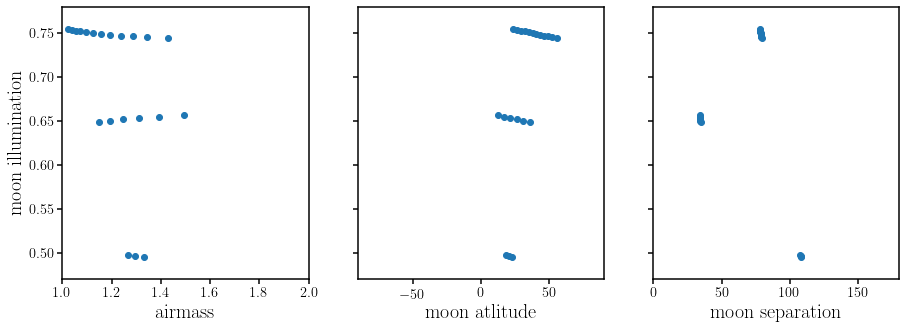

In [8]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(airmass, moon_ill)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(moon_alt, moon_ill)
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sub.scatter(moon_sep, moon_ill)
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

Note that we have no exposures during twilight so we can't validate the twilight contribution to the sky.

Text(0, 0.5, 'sun altitude')

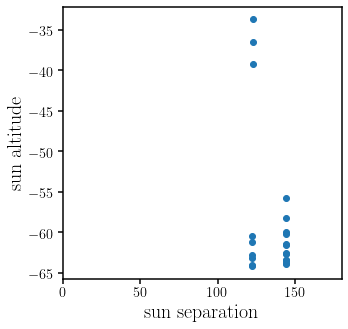

In [9]:
fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
sub.scatter(sun_sep, sun_alt)
sub.set_xlabel('sun separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_ylabel('sun altitude', fontsize=20)

Now lets compare how these sky fluxes to the fluxes predicted by our sky model for a handful of exposures

In [10]:
from astropy import units as u
from feasibgs import skymodel as Sky

def sky_model_notwi(airmass, moonill, moonalt, moonsep):
    ''' sky model is based on re-fit KS coefficients. 

    :return specsim_wave, Isky:
        returns wavelength [Angstrom] and sky flux [$10^{-17} erg/cm^{2}/s/\AA$]
    '''
    specsim_sky = Sky._specsim_initialize('desi')
    specsim_wave = specsim_sky._wavelength # Ang
    specsim_sky.airmass = airmass
    specsim_sky.moon.moon_phase = np.arccos(2.*moonill - 1)/np.pi
    specsim_sky.moon.moon_zenith = (90. - moonalt) * u.deg
    specsim_sky.moon.separation_angle = moonsep * u.deg

    # updated KS coefficients
    specsim_sky.moon.KS_CR = 458173.535128
    specsim_sky.moon.KS_CM0 = 5.540103
    specsim_sky.moon.KS_CM1 = 178.141045

    I_ks_rescale = specsim_sky.surface_brightness
    Isky = I_ks_rescale.value * (1.46/2.)**2 * np.pi #1.46 arcsec is the fiber core diamaeter

    return specsim_wave.value, Isky

In [11]:
def compare_sky(iexp): 
    is_exp = (sky_data['expid'] == uniq_exps[iexp])

    fig = plt.figure(figsize=(15,5))
    sub = fig.add_subplot(131)
    sub.scatter(airmass, moon_ill)
    sub.scatter(airmass[iexp], moon_ill[iexp])
    sub.set_xlabel('airmass', fontsize=20)
    sub.set_xlim(1., 2.)
    sub.set_ylabel('moon illumination', fontsize=20)

    sub = fig.add_subplot(132)
    sub.scatter(moon_alt, moon_ill)
    sub.scatter(moon_alt[iexp], moon_ill[iexp])
    sub.set_xlabel('moon atlitude', fontsize=20)
    sub.set_xlim(-90., 90.)
    sub.set_yticklabels([])
    sub.set_title("CMX BGS Exposures", fontsize=20)

    sub = fig.add_subplot(133)
    sub.scatter(moon_sep, moon_ill)
    sub.scatter(moon_sep[iexp], moon_ill[iexp])
    sub.set_xlabel('moon separation', fontsize=20)
    sub.set_xlim(0., 180.)
    sub.set_yticklabels([])

    fig = plt.figure(figsize=(10,5))
    sub = fig.add_subplot(111)
    sub.plot(sky_data['wave_b'], np.median(sky_data['sky_b'][is_exp,:], axis=0), c='C0')
    sub.plot(sky_data['wave_r'], np.median(sky_data['sky_r'][is_exp,:], axis=0), c='C1')
    sub.plot(sky_data['wave_z'], np.median(sky_data['sky_z'][is_exp,:], axis=0), c='C2')
    sub.set_xlabel(r'Wavelength [$\AA$]', fontsize=20)
    sub.set_ylabel(r'Flux [$10^{-17} erg/cm^{2}/s/\AA$]', fontsize=20)

    _wave, _Isky = sky_model_notwi(airmass[iexp], moon_ill[iexp], moon_alt[iexp], moon_sep[iexp])
    sub.plot(_wave, _Isky, c='k', ls='--', lw=0.5)
    sub.set_xlim(3600., 9800.)
    sub.set_ylim(0., 50)
    sub.set_title('airmass=%.2f, moon ill=%.2f, moon altitutde=%.1f, moon separation=%.1f, no twilight' % 
                 (airmass[iexp], moon_ill[iexp], moon_alt[iexp], moon_sep[iexp]), pad=15, fontsize=20) 
    return None

/anaconda2/envs/bgs/lib/python3.7/site-packages/speclite-0.8-py3.7.egg/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


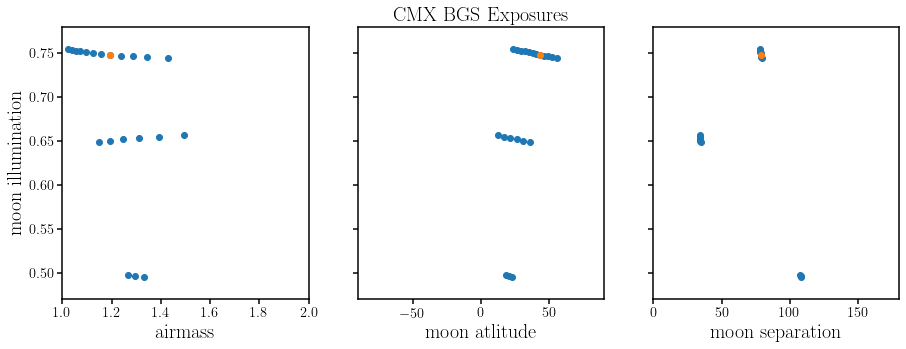

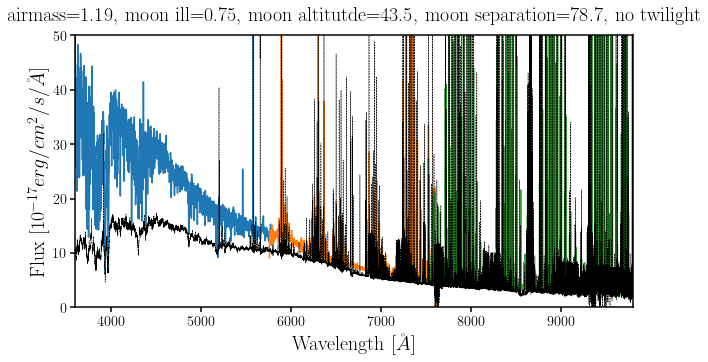

In [12]:
compare_sky(10)

/anaconda2/envs/bgs/lib/python3.7/site-packages/speclite-0.8-py3.7.egg/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


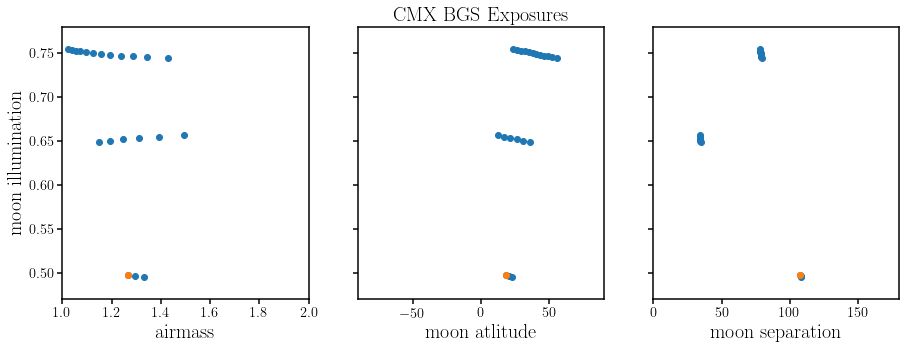

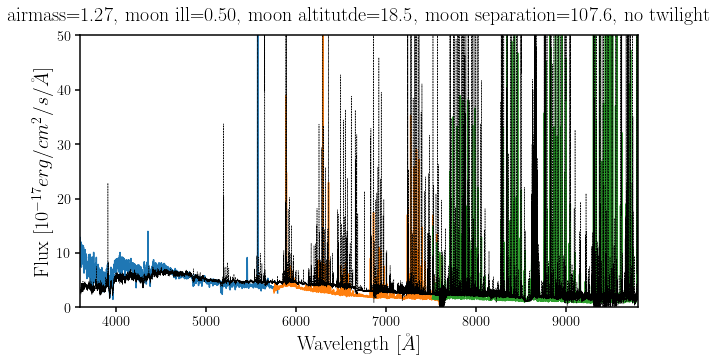

In [13]:
compare_sky(18)

/anaconda2/envs/bgs/lib/python3.7/site-packages/speclite-0.8-py3.7.egg/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


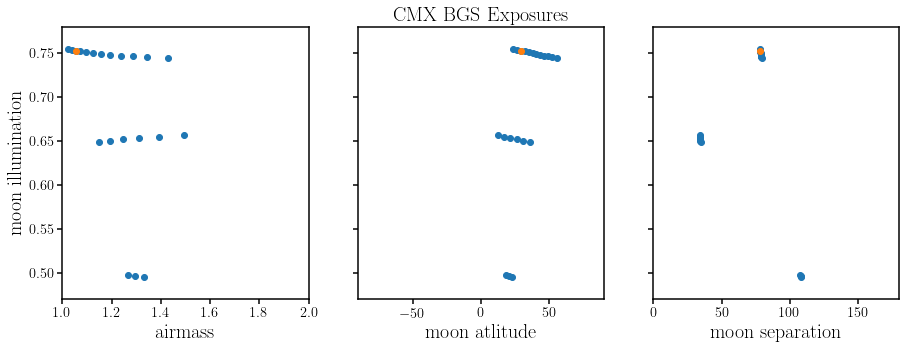

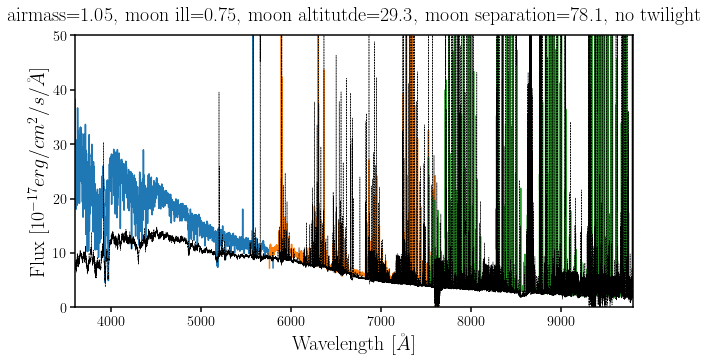

In [14]:
compare_sky(15)

Lets do a more quantitative comparison by looking at the ratio of the data and model sky fluxes at $4500\AA$. 

In [15]:
def get_continuum(flux): 
    cont = medfilt(flux, 151) 
    return cont

def data_over_model_4500(iexp): 
    ''' given exposure id, calculate (sky flux of data) / (sky flux of model) at 4500A
    '''
    is_exp = (sky_data['expid'] == uniq_exps[iexp])

    _sky_data = get_continuum(np.median(sky_data['sky_b'][is_exp,:], axis=0))
    sky_data_4500 = _sky_data[1125]
    
    
    _wave, _Isky = sky_model_notwi(airmass[iexp], moon_ill[iexp], moon_alt[iexp], moon_sep[iexp])
    sky_model = get_continuum(_Isky)
    sky_model_4500 = sky_model[9500]
    
    return sky_data_4500 / sky_model_4500

In [16]:
data_over_model = [data_over_model_4500(i) for i in range(len(uniq_exps))]

/anaconda2/envs/bgs/lib/python3.7/site-packages/speclite-0.8-py3.7.egg/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]
/anaconda2/envs/bgs/lib/python3.7/site-packages/speclite-0.8-py3.7.egg/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]
/anaconda2/envs/bgs/lib/python3.7/site-packages/speclite-0.8-py3.7.egg/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional in

/anaconda2/envs/bgs/lib/python3.7/site-packages/speclite-0.8-py3.7.egg/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


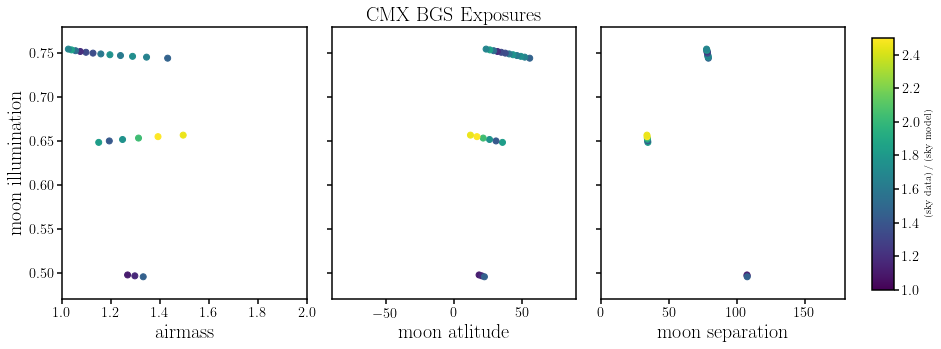

In [17]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(airmass, moon_ill, c=data_over_model, vmin=1., vmax=2.5)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(moon_alt, moon_ill, c=data_over_model, vmin=1., vmax=2.5)
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])
sub.set_title("CMX BGS Exposures", fontsize=20)

sub = fig.add_subplot(133)
sct = sub.scatter(moon_sep, moon_ill, c=data_over_model, vmin=1., vmax=2.5)
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.875, 0.15, 0.02, 0.7])
fig.colorbar(sct, cax=cbar_ax, label='(sky data) / (sky model)')